In [73]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import utils
from tqdm.notebook import tqdm
import xarray as xr
from torchsummary import summary
from matplotlib import cm as cmap

In [50]:
ds_CI02 = xr.load_dataset("data/CNN/CI02.xr").dropna(dim='nbtj')
ds_CI04 = xr.load_dataset("data/CNN/CI04.xr").dropna(dim='nbtj')
ds_CI06 = xr.load_dataset("data/CNN/CI06.xr").dropna(dim='nbtj')
ds_CI09 = xr.load_dataset("data/CNN/CI09.xr").dropna(dim='nbtj')
ds_CI21 = xr.load_dataset("data/CNN/CI21.xr").dropna(dim='nbtj')

data_list =[ds_CI02,ds_CI04,ds_CI06,ds_CI09,ds_CI21]

ds_CI02_norm = ds_CI02.copy()
ds_CI04_norm = ds_CI04.copy()
ds_CI06_norm = ds_CI06.copy()
ds_CI09_norm = ds_CI09.copy()
ds_CI21_norm = ds_CI21.copy()

data_norm_list =[ds_CI02_norm,ds_CI04_norm,ds_CI06_norm,ds_CI09_norm,ds_CI21_norm]

In [51]:
for k in range(5):

    vars = list(data_list[k].keys())
    vars = vars[1:9]
    for i in vars :
        v = data_list[k][i].to_numpy().reshape((data_list[k].dims['nbtj'],100))
        scaler = StandardScaler().fit(v)
        v_scaled = scaler.transform(v)
        v_scaled = v_scaled.reshape((data_list[k].dims['nbtj'],10,10))
        data_norm_list[k][i] = xr.DataArray(v_scaled,dims=['nbtj','y','x'])

In [52]:
data = xr.concat((ds_CI02_norm,ds_CI04_norm,ds_CI09_norm,ds_CI21_norm),dim='nbtj')
#data = ds_CI02_norm
test = ds_CI06_norm

In [53]:
# data = ds_CI06_norm.where(ds_CI06_norm.RX==1).dropna(dim='nbtj')
# test = ds_CI02_norm.where(ds_CI02_norm.RX==1).dropna(dim='nbtj')

In [54]:
import torch
from torch.utils.data import Dataset
import xarray as xr
import numpy as np

class CustomTensorDataset(Dataset):
  def __init__(self, dataset, transform_list=None):
    data_X = dataset[['schmid','diff_schmid','misangle','work','eqStrain','eqStress','act_pr','act_py'
                      ]].to_array().to_numpy().reshape((dataset.dims['nbtj'],8,10,10))
    data_y = dataset['RX'].to_numpy()
    X_tensor, y_tensor = torch.tensor(data_X), torch.tensor(data_y)
    #X_tensor, y_tensor = Tensor(data_X), Tensor(data_y)
    tensors = (X_tensor, y_tensor)
    assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
    self.tensors = tensors
    self.transforms = transform_list

  def __getitem__(self, index):
    x = self.tensors[0][index]

    if self.transforms:
      #for transform in self.transforms: 
      #  x = transform(x)
      x = self.transforms(x)

    y = self.tensors[1][index]

    return x, y

  def __len__(self):
    return self.tensors[0].size(0)

In [55]:
data_train = CustomTensorDataset(data)
data_test = CustomTensorDataset(test)

In [56]:
y_test = data_test.tensors[1]

In [57]:
EPOCHS = 50
BATCH_SIZE = 16
LEARNING_RATE = 0.0001

In [58]:
trainloader = DataLoader(data_train,batch_size=BATCH_SIZE,shuffle=True)
testloader =DataLoader(data_test,batch_size=1)

In [59]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = self.conv_block(c_in=8, c_out=64, kernel_size=3)
        self.conv2 = self.conv_block(c_in=64, c_out=128, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d(0.1)
        self.dense = nn.Linear(128, 1)
        self.prelu = nn.PReLU()

    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = x.reshape((x.shape[0],x.shape[1]))
        x = self.prelu(self.dense(x))
        return x

    def conv_block(self, c_in, c_out,  **kwargs):
        seq_block = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, **kwargs),
            nn.BatchNorm2d(num_features=c_out),
            nn.PReLU()
        )        
        return seq_block




In [60]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [61]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

def binary_rec(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    cm = torch.zeros(2, 2)
    for t, p in zip(y_test.long(), y_pred_tag.long()):
        cm[t, p] += 1
    rec = cm[1,1] / (cm[1,1] + cm[1,0])
    rec = torch.round(rec * 100)
    
    return rec

def binary_spec(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    
    cm = torch.zeros(2, 2)
    for t, p in zip(y_test.long(), y_pred_tag.long()):
        cm[t, p] += 1

    spec = cm[0,0] / (cm[0,0] + cm[0,1])
    spec = torch.round(spec * 100)
    
    return spec

In [62]:
model = Net().float()

In [63]:
print(model)

Net(
  (conv1): Sequential(
    (0): Conv2d(8, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.1, inplace=False)
  (dense): Linear(in_features=128, out_features=1, bias=True)
  (prelu): PReLU(num_parameters=1)
)


In [64]:
summary(model,(8,10,10))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 8, 8]           4,672
       BatchNorm2d-2             [-1, 64, 8, 8]             128
             PReLU-3             [-1, 64, 8, 8]               1
         MaxPool2d-4             [-1, 64, 4, 4]               0
            Conv2d-5            [-1, 128, 2, 2]          73,856
       BatchNorm2d-6            [-1, 128, 2, 2]             256
             PReLU-7            [-1, 128, 2, 2]               1
         MaxPool2d-8            [-1, 128, 1, 1]               0
            Linear-9                    [-1, 1]             129
            PReLU-10                    [-1, 1]               1
Total params: 79,044
Trainable params: 79,044
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.11
Params size (MB): 0.30
Estimated Tot

In [65]:

model = Net().float()
model.to(device)
#print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

model.train()
loss_c = []
acc_train_c = []
acc_test_c = []
rec_train_c = []
rec_test_c = []
spec_train_c = []
spec_test_c = []

for e in tqdm(range(1, EPOCHS+1)):
    epoch_loss = 0
    epoch_acc = 0
    epoch_rec = 0
    epoch_spec = 0
    for X_batch, y_batch in trainloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        X_batch = X_batch.float() 
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        rec = binary_rec(y_pred, y_batch.unsqueeze(1))
        spec = binary_spec(y_pred, y_batch.unsqueeze(1))
        
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_rec += rec.item()
        epoch_spec += spec.item()

    loss_c.append(epoch_loss/len(trainloader))
    acc_train_c.append(epoch_acc/len(trainloader))
    rec_train_c.append(epoch_rec/len(trainloader))
    spec_train_c.append(epoch_spec/len(trainloader))

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(trainloader):.5f} | Acc: {epoch_acc/len(trainloader):.3f} | Rec: {epoch_rec/len(trainloader):.3f} | Spec: {epoch_spec/len(trainloader):.3f}')

    y_pred_list = []

    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in testloader:
            X_batch = X_batch.float()
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

    cm = confusion_matrix(y_test, y_pred_list)

    acc_test_c.append((cm[0,0]+cm[1,1])/sum(sum(cm)))
    rec_test_c.append((cm[1,1] / (cm[1,1] + cm[1,0])))
    spec_test_c.append((cm[0,0] / (cm[0,0] + cm[0,1])))

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 001: | Loss: 0.69613 | Acc: 56.062 | Rec: 31.906 | Spec: 71.375
Epoch 002: | Loss: 0.65730 | Acc: 65.750 | Rec: 14.938 | Spec: 93.656
Epoch 003: | Loss: 0.64125 | Acc: 64.031 | Rec: 0.000 | Spec: 100.000
Epoch 004: | Loss: 0.63830 | Acc: 63.625 | Rec: 0.000 | Spec: 100.000
Epoch 005: | Loss: 0.63168 | Acc: 64.344 | Rec: 2.844 | Spec: 99.656
Epoch 006: | Loss: 0.62089 | Acc: 66.031 | Rec: 8.719 | Spec: 99.750
Epoch 007: | Loss: 0.61177 | Acc: 66.469 | Rec: 9.062 | Spec: 98.562
Epoch 008: | Loss: 0.60487 | Acc: 67.438 | Rec: 14.312 | Spec: 98.250
Epoch 009: | Loss: 0.60200 | Acc: 69.031 | Rec: 18.156 | Spec: 97.219
Epoch 010: | Loss: 0.59905 | Acc: 66.906 | Rec: 10.469 | Spec: 99.406
Epoch 011: | Loss: 0.58236 | Acc: 71.000 | Rec: 25.594 | Spec: 96.250
Epoch 012: | Loss: 0.57792 | Acc: 70.094 | Rec: 23.781 | Spec: 97.406
Epoch 013: | Loss: 0.57010 | Acc: 71.500 | Rec: 23.906 | Spec: 98.375
Epoch 014: | Loss: 0.55471 | Acc: 72.969 | Rec: 30.938 | Spec: 96.469
Epoch 015: | Loss: 0.54

In [66]:
y_pred_list = []

model.eval()
with torch.no_grad():
    for X_batch, y_batch in tqdm(testloader):
        X_batch = X_batch.float()
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

  0%|          | 0/216 [00:00<?, ?it/s]

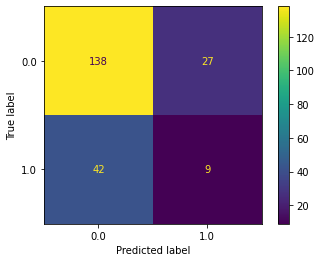

In [67]:
ConfusionMatrixDisplay.from_predictions(y_test,y_pred_list)
plt.show()

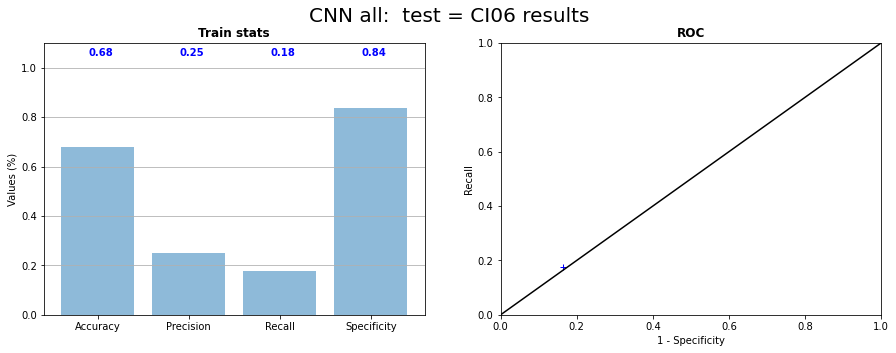

In [68]:
from sklearn import metrics
acc = metrics.accuracy_score(y_test, y_pred_list)
prec = metrics.precision_score(y_test, y_pred_list)
rec = metrics.recall_score(y_test, y_pred_list)
cm = metrics.confusion_matrix(y_test, y_pred_list)
spec = cm[0,0] / (cm[0,0] + cm[0,1])
utils.plot_lstats(acc,prec,rec,spec,model="CNN all:  test = CI06")

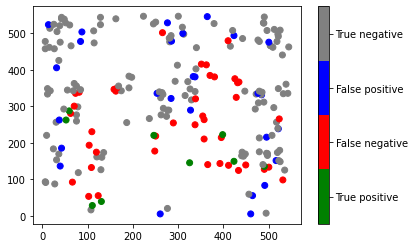

In [69]:
coords = test.coords.get('coords')
from matplotlib import colors
col = -(np.array(y_pred_list)+2*np.array(y_test))
cmap = colors.ListedColormap(['green','red','blue','gray'])
bounds=[-3.5,-2.5,-1.5,-0.5,0.5]
norm = colors.BoundaryNorm(bounds, cmap.N)

plot = plt.scatter(coords[0],coords[1],c=col,cmap=cmap,norm=norm)
cbar = plt.colorbar(plot, cmap=cmap, norm=norm, boundaries=bounds, ticks=[-3, -2, -1,0])

cbar.set_ticklabels(["True positive","False negative","False positive","True negative"])

Text(0, 0.5, 'recall')

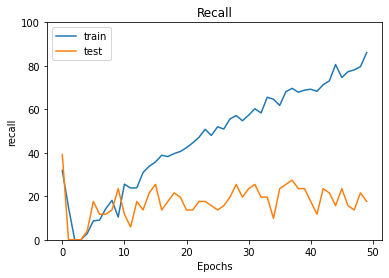

In [70]:
x = np.arange(len(rec_test_c))
plt.plot(x,rec_train_c)
plt.plot(x,np.array(rec_test_c)*100)
plt.ylim([0,100])
plt.legend(['train','test'])
plt.title("Recall")
plt.xlabel("Epochs")
plt.ylabel("recall")

Text(0, 0.5, 'specif')

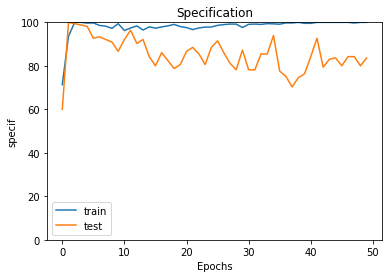

In [71]:
x = np.arange(len(rec_test_c))
plt.plot(x,spec_train_c)
plt.plot(x,np.array(spec_test_c)*100)
plt.ylim([0,100])
plt.legend(['train','test'])
plt.title("Specification")
plt.xlabel("Epochs")
plt.ylabel("specif")

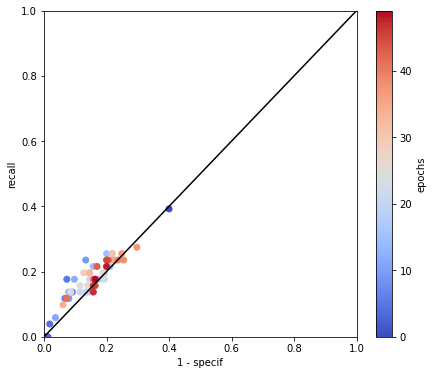

In [74]:
colormap = cmap.coolwarm
plt.figure(figsize=(7,6))

plt.scatter(1-np.array(spec_test_c),np.array(rec_test_c),c=np.arange(len(rec_test_c)),cmap=colormap)
plt.xlim([0,1])
plt.ylim([0,1])
plt.plot([0,1],[0,1],"k")
cb = plt.colorbar()
cb.set_label('epochs')
plt.xlabel('1 - specif')
plt.ylabel('recall')
plt.show()
